In [ ]:
# Copyright (c) Sebastian Raschka under Apache License 2.0 (see LICENSE.txt).
# Source for "Build a Large Language Model From Scratch"
#   - https://www.manning.com/books/build-a-large-language-model-from-scratch
# Code: https://github.com/rasbt/LLMs-from-scratch

import matplotlib.pyplot as plt
import os
import requests
import torch
import tiktoken

from previous_chapters import GPTModel, create_dataloader_v1, generate_text_simple


def text_to_token_ids(text, tokenizer):
    """
    사람이 읽는 텍스트 문자열을 모델이 이해하는 토큰 ID 텐서로 변환합니다.
    """
    encoded = tokenizer.encode(text)
    
    # 모델은 입력으로 (Batch_Size, Sequence_Length)의 2차원 텐서를 요구합니다.
    # 하지만 여기서는 문장 1개이므로 Batch_Size가 없습니다.
    # 따라서 .unsqueeze(0)를 사용하여 가짜 배치 차원을 추가합니다.
    # 예: [12, 34, 56] -> [[12, 34, 56]] (Shape: [1, seq_len])
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) 
    return encoded_tensor


def token_ids_to_text(token_ids, tokenizer):
    """
    모델이 뱉어낸 토큰 ID 텐서를 사람이 읽을 수 있는 텍스트로 변환합니다.
    """
    # 디코딩을 위해 불필요한 배치 차원을 제거합니다.
    # 예: [[12, 34, 56]] -> [12, 34, 56]
    flat = token_ids.squeeze(0) 
    return tokenizer.decode(flat.tolist())


def calc_loss_batch(input_batch, target_batch, model, device):
    """
    하나의 배치(Batch)에 대해 모델의 예측값과 실제값 사이의 오차(Loss)를 계산합니다.
    """
    # 데이터를 GPU(또는 설정된 device)로 이동
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    
    # 1. 모델의 순전파(Forward Pass)
    # logits shape: (batch_size, sequence_length, vocab_size)
    logits = model(input_batch)
    
    # 2. 손실 계산 (CrossEntropyLoss)
    # PyTorch의 CrossEntropyLoss는 입력을 (N, C) 형태로 받기를 원합니다.
    #   - N: 전체 샘플 수 (여기서는 Batch_size * Sequence_length)
    #   - C: 클래스 수 (여기서는 Vocab_size)
    # 따라서 3차원 텐서를 2차원으로 평탄화(flatten) 해야 합니다.
    
    # logits.flatten(0, 1) -> (batch_size * sequence_length, vocab_size)
    # target_batch.flatten() -> (batch_size * sequence_length)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), 
        target_batch.flatten()
    )
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    """
    데이터 로더 전체(또는 일부)를 돌면서 평균 손실을 계산합니다.
    훈련에는 관여하지 않고, 오직 '평가(Evaluation)' 목적으로만 쓰입니다.
    """
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # 평가 시간을 단축하기 위해 전체 데이터를 다 보지 않고 일부만 볼 수 있게 설정
        num_batches = min(num_batches, len(data_loader))
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item() # 텐서에서 실수값(float)만 추출하여 누적
        else:
            break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """
    현재 모델의 성능을 훈련 세트와 검증 세트 각각에 대해 평가합니다.
    """
    model.eval() # [중요] 평가 모드 전환: Dropout이나 BatchNorm 등의 동작이 변경됨
    
    with torch.no_grad(): # [중요] 기울기(Gradient) 계산 끔 -> 메모리 절약 및 속도 향상
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
        
    model.train() # 평가가 끝나면 다시 훈련 모드로 복귀해야 함
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    """
    훈련 중간중간 모델이 문장을 어떻게 생성하는지 눈으로 확인하기 위한 함수입니다.
    """
    model.eval() # 평가 모드
    context_size = model.pos_emb.weight.shape[0] # 모델이 처리 가능한 최대 길이
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        
        # 출력이 너무 길어지면 보기 힘드므로 줄바꿈을 공백으로 변경
        print(decoded_text.replace("\n", " "))  
    
    model.train() # 훈련 모드 복귀


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    """
    [핵심] 모델 훈련을 담당하는 메인 루프입니다.
    """
    # 로그 저장을 위한 리스트들
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen = 0
    global_step = -1

    # Epoch: 전체 데이터셋을 한 번 훑는 단위
    for epoch in range(num_epochs):
        model.train()  # 훈련 시작 전 반드시 train 모드 설정

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # [Step 1] 이전 배치에서 계산된 기울기 초기화 (필수)
            
            # [Step 2] 순전파 및 손실 계산
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            
            # [Step 3] 역전파 (Backpropagation): 각 파라미터별 기울기(Gradient) 계산
            loss.backward() 
            
            # [Step 4] 가중치 업데이트: 계산된 기울기를 이용해 파라미터 수정
            optimizer.step() 
            
            tokens_seen += input_batch.numel() # 처리한 토큰 수 카운트
            global_step += 1

            # 일정 스텝마다 검증(Evaluation) 수행 및 로그 출력
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 한 에포크가 끝날 때마다 샘플 문장을 생성하여 모델이 똑똑해지고 있는지 확인
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    """
    훈련 진행 상황(Loss 변화)을 시각화하는 함수입니다.
    X축을 'Epoch'와 '처리한 토큰 수' 두 가지 기준으로 보여줍니다.
    """
    fig, ax1 = plt.subplots()

    # 기본 X축: Epoch 기준
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    # 보조 X축 (상단): 처리한 토큰 수(Tokens seen) 기준
    ax2 = ax1.twiny() 
    ax2.plot(tokens_seen, train_losses, alpha=0) # 투명한 그래프로 축만 생성
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout() 
    # plt.show() # 주피터 노트북 환경이면 주석 해제


def main(gpt_config, settings):
    # 랜덤 시드 고정 (실험 재현성을 위해)
    torch.manual_seed(123)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ##############################
    # 1. 데이터 준비
    ##############################
    file_path = "datas/the-verdict.txt"
    url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

    if not os.path.exists(file_path):
        response = requests.get(url, timeout=30)
        response.raise_for_status()
        text_data = response.text
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)
    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    ##############################
    # 2. 모델 및 옵티마이저 초기화
    ##############################
    model = GPTModel(gpt_config)
    model.to(device) # 모델을 GPU 메모리로 올림
    
    # AdamW: 가중치 감쇠(Weight Decay)가 적용된 Adam 옵티마이저
    # Weight Decay는 모델이 너무 복잡해지지 않도록 규제(Regularization)하는 역할
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=settings["learning_rate"], weight_decay=settings["weight_decay"]
    )

    ##############################
    # 3. 데이터 로더 구축
    ##############################
    # 전체 텍스트를 9:1 비율로 훈련용과 검증용으로 나눔
    train_ratio = 0.90
    split_idx = int(train_ratio * len(text_data))

    # 훈련 데이터 로더: 순서를 섞음(Shuffle=True)
    train_loader = create_dataloader_v1(
        text_data[:split_idx],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=True,
        shuffle=True,
        num_workers=0
    )

    # 검증 데이터 로더: 순서를 섞지 않음(Shuffle=False) -> 평가는 일관되게
    val_loader = create_dataloader_v1(
        text_data[split_idx:],
        batch_size=settings["batch_size"],
        max_length=gpt_config["context_length"],
        stride=gpt_config["context_length"],
        drop_last=False,
        shuffle=False,
        num_workers=0
    )

    ##############################
    # 4. 훈련 시작
    ##############################
    tokenizer = tiktoken.get_encoding("gpt2") # BPE 토크나이저

    train_losses, val_losses, tokens_seen = train_model_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=settings["num_epochs"], eval_freq=5, eval_iter=1,
        start_context="Every effort moves you", tokenizer=tokenizer
    )

    return train_losses, val_losses, tokens_seen, model


def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    """
    고급 텍스트 생성 함수입니다. (Top-k 샘플링 & Temperature Scaling 포함)
    
    Args:
        idx: 현재 문맥 (Shape: Batch, Time)
        temperature: 0이면 결정적(Greedy), 높을수록 창의적/랜덤
        top_k: 확률 상위 k개만 후보로 남김 (이상한 단어 생성 방지)
    """

    # 지정된 토큰 수만큼 반복 생성
    for _ in range(max_new_tokens):
        
        # 1. 문맥 자르기 (Context Cropping)
        # 모델이 처리할 수 있는 최대 길이(context_size)를 넘지 않도록 뒤쪽만 남김
        idx_cond = idx[:, -context_size:]
        
        # 2. 모델 예측
        with torch.no_grad():
            logits = model(idx_cond)
        
        # 3. 다음 단어 예측을 위해 '마지막 시점'의 로짓만 추출
        # logits shape: (batch, seq_len, vocab_size) -> (batch, vocab_size)
        logits = logits[:, -1, :]

        # 4. Top-k 필터링
        # 확률이 낮은 꼬리 부분의 단어들을 아예 배제함
        if top_k is not None:
            # 상위 k개의 값과 인덱스를 구함
            top_logits, _ = torch.topk(logits, top_k)
            # k번째 값(최소 허용치)을 구함
            min_val = top_logits[:, -1]
            # 최소 허용치보다 작은 로짓들은 -무한대로 보내버림 (Softmax 후 0이 됨)
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # 5. Temperature Scaling 및 샘플링
        if temperature > 0.0:
            # 온도로 나눠서 분포를 평탄하게(다양하게) 혹은 뾰족하게(확실하게) 만듦
            logits = logits / temperature
            
            # 수치 안정성을 위해 최댓값을 빼줌 (결과 확률은 동일)
            logits = logits - logits.max(dim=-1, keepdim=True).values

            # Softmax를 통해 확률 분포로 변환
            probs = torch.softmax(logits, dim=-1)

            # 확률 분포에 기반하여 랜덤하게 하나 뽑음 (Multinomial Sampling)
            idx_next = torch.multinomial(probs, num_samples=1)

        # 6. Greedy Sampling (Temperature=0일 때)
        else:
            # 확률이 가장 높은 단어 하나를 무조건 선택
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        # 7. 종료 조건 확인 (EOS 토큰이 나오면 중단)
        if idx_next == eos_id:
            break

        # 8. 생성된 토큰 이어붙이기
        # 기존 문장(idx) 뒤에 새로 뽑은 토큰(idx_next)을 붙여 다음 스텝의 입력으로 씀
        idx = torch.cat((idx, idx_next), dim=1)

    return idx



Ep 1 (Step 000000): Train loss 9.980, Val loss 9.846
Ep 1 (Step 000005): Train loss 7.850, Val loss 8.048
Every effort moves you,,,,,,,,,,,,,,.                                   
Ep 2 (Step 000010): Train loss 6.268, Val loss 6.802
Ep 2 (Step 000015): Train loss 5.820, Val loss 6.572
Every effort moves you, a,, a,, the,,,,.                                     
Ep 3 (Step 000020): Train loss 5.905, Val loss 6.540
Ep 3 (Step 000025): Train loss 5.247, Val loss 6.552
Every effort moves you                                                  
Ep 4 (Step 000030): Train loss 4.356, Val loss 6.489
Ep 4 (Step 000035): Train loss 4.772, Val loss 6.285
Every effort moves you, and, and he was a of the picture, and I had been.          "I was a, and I had been, and he was a, and, and the picture.   
Ep 5 (Step 000040): Train loss 3.753, Val loss 6.218
Every effort moves you know it to see a little of the house--I-chairs me in a little to me--as of the fact of the Riv you know it.     "Oh, and he had 

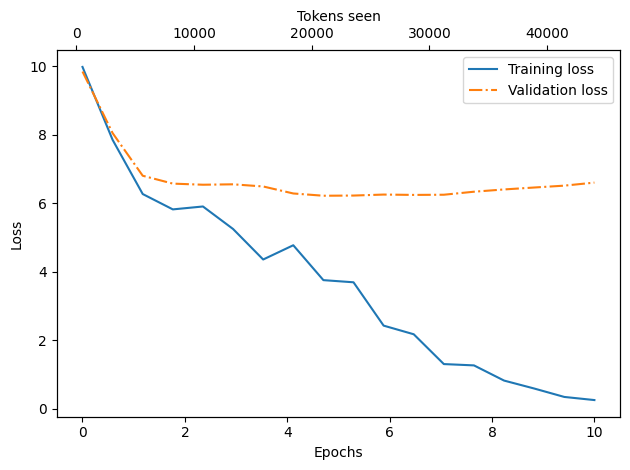

In [5]:

# GPT-2 Small (124M) 모델 설정
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # 어휘 크기
    "context_length": 256,  # 훈련 속도를 위해 원본(1024)보다 줄임
    "emb_dim": 768,         # 임베딩 벡터 차원
    "n_heads": 12,          # 어텐션 헤드 개수
    "n_layers": 12,         # 레이어 깊이
    "drop_rate": 0.1,       # 과적합 방지 드롭아웃
    "qkv_bias": False       
}

# 학습 하이퍼파라미터
OTHER_SETTINGS = {
    "learning_rate": 5e-4, 
    "num_epochs": 10,       
    "batch_size": 2,        
    "weight_decay": 0.1     
}

###########################
# 메인 실행: 훈련
###########################
train_losses, val_losses, tokens_seen, model = main(GPT_CONFIG_124M, OTHER_SETTINGS)

###########################
# 훈련 결과 시각화 및 저장
###########################

# 에포크 축 생성 (0부터 num_epochs까지)
epochs_tensor = torch.linspace(0, OTHER_SETTINGS["num_epochs"], len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)
plt.savefig("outputs/loss.pdf")

# 모델 저장 및 로드 테스트
torch.save(model.state_dict(), "outputs/model.pth")

# 디바이스 설정 (모델 로드 전에 정의 필요)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 다시 불러오기 테스트
model = GPTModel(GPT_CONFIG_124M) # 1. 빈 모델 생성 (현재 CPU에 있음)
model.load_state_dict(torch.load("outputs/model.pth", weights_only=True)) # 2. 가중치 로드
model.to(device) # <--- [핵심 수정] 3. 모델을 GPU로 이동시켜야 함

torch.manual_seed(123)
###########################
# 생성 테스트 (Inference)
###########################
tokenizer = tiktoken.get_encoding("gpt2")

# 훈련된 모델로 텍스트 생성 시도
# Temperature=1.4로 설정하여 다소 창의적/다양한 문장 생성 유도
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))